# Bert Model for Poem Recognition

## Environment Setup


In [1]:
!pip install pytorch-pretrained-bert pytorch-nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 5.6 MB/s 
     |████████████████████████████████| 90 kB 3.9 MB/s 
     |████████████████████████████████| 132 kB 7.6 MB/s 
     |████████████████████████████████| 10.2 MB 24.4 MB/s 
     |████████████████████████████████| 79 kB 3.0 MB/s 
     |████████████████████████████████| 140 kB 71.5 MB/s 
     |████████████████████████████████| 127 kB 45.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm,trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import spacy

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from imblearn.over_sampling import SMOTE

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

## Load Dataset


In [5]:
en_model = spacy.load('en_core_web_sm')
stopwords = en_model.Defaults.stop_words
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

MAX_LEN = 80
tokens_list = []

# Load Training Data
with open('/content/drive/MyDrive/Colab Notebooks/tokens_list_bert.txt') as f:
  for line in f:
    tokens = [token.strip() for token in line.split(',')]
    clean_tokens = [tokens[0]]
    for i in range(1, len(tokens)-1):
      if tokens[i] not in stopwords and tokens[i] in tokenizer.vocab:
        clean_tokens.append(tokens[i])
      if len(clean_tokens) == MAX_LEN - 1:
        break
    clean_tokens.append(tokens[len(tokens)-1])
    tokens_list.append(clean_tokens)
f.close()

input_ids = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokens_list]
input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, maxlen=MAX_LEN, dtype="int", truncating="post", padding="post")

100%|██████████| 231508/231508 [00:00<00:00, 2711506.64B/s]


In [6]:
# Load Training Labels
labels = []
with open('/content/drive/MyDrive/Colab Notebooks/labels.txt') as f:
  for label in f:
    labels.append(int(label.strip()))
f.close()

In [7]:
# smote = SMOTE()
# input_ids, labels = smote.fit_resample(input_ids, labels)

In [8]:
attention_masks = []
for seq in input_ids:
  seq_mask = np.array([float(i>0) for i in seq])
  attention_masks.append(seq_mask)
attention_masks = np.array(attention_masks)

## Load Bert Model

In [20]:
# Preprocessing input dataset
batch_size = 16
train_inputs, test_inputs, train_labels, test_labels, train_masks, test_masks = train_test_split(input_ids, labels, attention_masks, random_state=100, test_size=0.1)
train_inputs, validtion_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(train_inputs, train_labels, train_masks, random_state=100, test_size=0.12)

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validtion_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [21]:
# Loading Bert Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

In [22]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

## Training

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 2.0570156508021884


Epoch:   7%|▋         | 1/15 [00:11<02:34, 11.03s/it]

Validation Accuracy: 0.19285714285714287
Train loss: 1.9717706872357263


Epoch:  13%|█▎        | 2/15 [00:22<02:26, 11.23s/it]

Validation Accuracy: 0.19285714285714287
Train loss: 1.889748560057746


Epoch:  20%|██        | 3/15 [00:33<02:14, 11.23s/it]

Validation Accuracy: 0.3125
Train loss: 1.8173163897461362


Epoch:  27%|██▋       | 4/15 [00:44<02:03, 11.19s/it]

Validation Accuracy: 0.4482142857142857
Train loss: 1.6020639969242945


Epoch:  33%|███▎      | 5/15 [00:55<01:51, 11.14s/it]

Validation Accuracy: 0.35892857142857143
Train loss: 1.3510508156485028


Epoch:  40%|████      | 6/15 [01:06<01:39, 11.10s/it]

Validation Accuracy: 0.4732142857142857
Train loss: 1.010612717933125


Epoch:  47%|████▋     | 7/15 [01:17<01:28, 11.07s/it]

Validation Accuracy: 0.43571428571428567
Train loss: 0.7376123501194848


Epoch:  53%|█████▎    | 8/15 [01:28<01:17, 11.05s/it]

Validation Accuracy: 0.39821428571428574
Train loss: 0.586461222006215


Epoch:  60%|██████    | 9/15 [01:39<01:06, 11.05s/it]

Validation Accuracy: 0.4
Train loss: 0.4773711549739043


Epoch:  67%|██████▋   | 10/15 [01:50<00:55, 11.05s/it]

Validation Accuracy: 0.35892857142857143
Train loss: 0.35921257982651394


Epoch:  73%|███████▎  | 11/15 [02:02<00:44, 11.09s/it]

Validation Accuracy: 0.39642857142857146
Train loss: 0.2883811192587018


Epoch:  80%|████████  | 12/15 [02:13<00:33, 11.13s/it]

Validation Accuracy: 0.38392857142857145
Train loss: 0.2590074611103369


Epoch:  87%|████████▋ | 13/15 [02:24<00:22, 11.11s/it]

Validation Accuracy: 0.3732142857142857
Train loss: 0.18078789922098318


Epoch:  93%|█████████▎| 14/15 [02:35<00:11, 11.09s/it]

Validation Accuracy: 0.3607142857142857
Train loss: 0.14191439587415922


Epoch: 100%|██████████| 15/15 [02:46<00:00, 11.10s/it]

Validation Accuracy: 0.38392857142857145


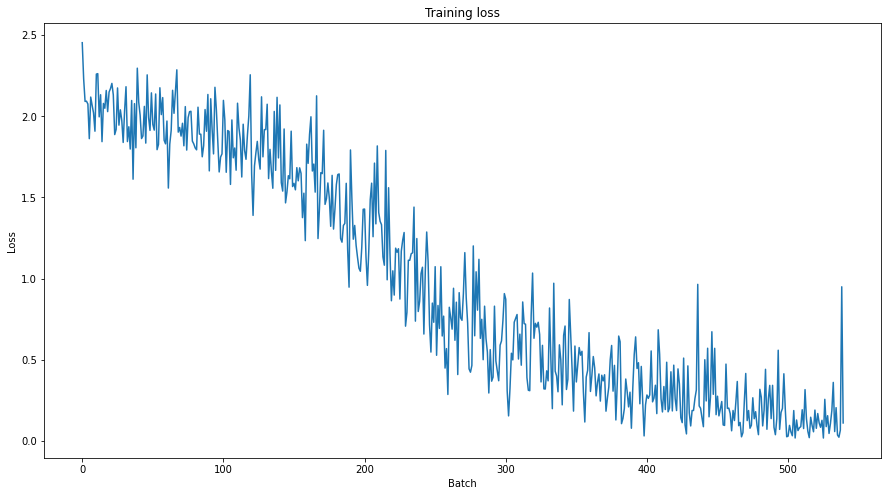

<Figure size 432x288 with 0 Axes>

In [23]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=0)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
  
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 15

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()
plt.savefig('/content/loss.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

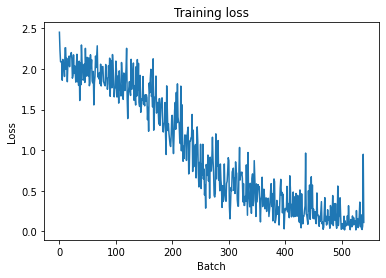

In [31]:
from google.colab import files
# plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.savefig('/content/aa.png')
files.download('/content/aa.png')

In [24]:
prediction_inputs = torch.tensor(test_inputs)
prediction_masks = torch.tensor(test_masks)
prediction_labels = torch.tensor(test_labels)

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

## Prediction on test set
# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions , true_labels = [], []
# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
  
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []
for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)
  
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

print('Classification accuracy using BERT Fine Tuning: {0:0.2%}'.format(matthews_corrcoef(flat_true_labels, flat_predictions)))


Classification accuracy using BERT Fine Tuning: 58.61%


In [25]:
print(accuracy_score(flat_predictions, flat_true_labels))
print(f1_score(flat_predictions, flat_true_labels,average='weighted'))
print(recall_score(flat_predictions, flat_true_labels,average='weighted'))
print(precision_score(flat_predictions, flat_true_labels,average='weighted'))


0.6388888888888888
0.6482682752503724
0.6388888888888888
0.7322455322455323
